# Msc Data Analytics Project: CA2 - Semester 2

## Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, to_timestamp
from pyspark.sql.types import IntegerType, StringType


In [2]:
import pyspark.sql.functions as F

In [3]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import warnings

# Machine Learning and preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Deep Learning
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import regularizers
from keras.optimizers import Adam

# Time Series Analysis
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Spark related imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, to_timestamp
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, StringType

# Text analysis
from textblob import TextBlob

# Dashboard and plotting
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go

# Model loading and saving
import joblib

warnings.filterwarnings('ignore')  # Suppress warnings

2023-11-07 23:26:43.995450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Storage and Processing

In [4]:
# Initialize SparkSession with MongoDB support
spark = SparkSession \
    .builder \
    .appName("PySparkSQL") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/ProjectTweets.ProjectTweets") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/ProjectTweets.ProjectTweets") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .getOrCreate()

# Define the path to the CSV file on VM Machine
file_path = "/home/hduser/Desktop/ProjectTweets.csv"

# Load the CSV data into a DataFrame
tweets_df = spark.read.format("csv").option("header", "false").option("inferSchema", "true").load(file_path)

# Rename the columns according to the CSV structure
tweets_df = tweets_df.withColumnRenamed("_c0", "Sequencial") \
                     .withColumnRenamed("_c1", "Serial_Number") \
                     .withColumnRenamed("_c2", "Date") \
                     .withColumnRenamed("_c3", "NO_QUERY") \
                     .withColumnRenamed("_c4", "User_Name") \
                     .withColumnRenamed("_c5", "Tweet")

# Use the old timestamp format that matches the legacy parser
old_timestamp_format = "EEE MMM dd HH:mm:ss z yyyy"
tweets_df = tweets_df.withColumn("Date", to_timestamp(tweets_df["Date"], old_timestamp_format))

# Drop the unnecessary columns
tweets_df = tweets_df.drop("Serial_Number","Sequencial", "NO_QUERY", "User_Name")

# Show the DataFrame to verify the columns are dropped
tweets_df.show()

# Write the DataFrame to MongoDB
tweets_df.write.format("mongo").mode("append").save()

# Read the DataFrame from MongoDB
loaded_tweets_df = spark.read.format("mongo").load()


# Show the DataFrame loaded from MongoDB to verify
loaded_tweets_df.show()

warnings.filterwarnings('ignore')  # Suppress warnings

:: loading settings :: url = jar:file:/home/hduser/miniconda3/envs/myenv/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/hduser/.ivy2/cache
The jars for the packages stored in: /home/hduser/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-824b631e-1952-492e-8e1f-849627afcba4;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 270ms :: artifacts dl 10ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts

+-------------------+--------------------+
|               Date|               Tweet|
+-------------------+--------------------+
|2009-04-07 06:19:45|@switchfoot http:...|
|2009-04-07 06:19:49|is upset that he ...|
|2009-04-07 06:19:53|@Kenichan I dived...|
|2009-04-07 06:19:57|my whole body fee...|
|2009-04-07 06:19:57|@nationwideclass ...|
|2009-04-07 06:20:00|@Kwesidei not the...|
|2009-04-07 06:20:03|         Need a hug |
|2009-04-07 06:20:03|@LOLTrish hey  lo...|
|2009-04-07 06:20:05|@Tatiana_K nope t...|
|2009-04-07 06:20:09|@twittera que me ...|
|2009-04-07 06:20:16|spring break in p...|
|2009-04-07 06:20:17|I just re-pierced...|
|2009-04-07 06:20:19|@caregiving I cou...|
|2009-04-07 06:20:19|@octolinz16 It it...|
|2009-04-07 06:20:20|@smarrison i woul...|
|2009-04-07 06:20:20|@iamjazzyfizzle I...|
|2009-04-07 06:20:22|Hollis' death sce...|
|2009-04-07 06:20:25|about to file taxes |
|2009-04-07 06:20:31|@LettyA ahh ive a...|
|2009-04-07 06:20:34|@FakerPattyPattz ...|
+----------

+-------------------+--------------------+--------------------+
|               Date|               Tweet|                 _id|
+-------------------+--------------------+--------------------+
|2009-04-18 16:51:40|@ctribe I hope yo...|{654ac7cc2891b16e...|
|2009-04-18 16:51:39|@Boy_Kill_Boy Nop...|{654ac7cc2891b16e...|
|2009-04-18 16:51:41|@marty0518 Someti...|{654ac7cc2891b16e...|
|2009-04-18 16:51:41|so i guesss im no...|{654ac7cc2891b16e...|
|2009-04-18 16:51:42|@DaiLS I do that,...|{654ac7cc2891b16e...|
|2009-04-18 16:51:43|trendy topic - Re...|{654ac7cc2891b16e...|
|2009-04-18 16:51:43|@firsttiger Real ...|{654ac7cc2891b16e...|
|2009-04-18 16:51:43|@Dragoncade I see...|{654ac7cc2891b16e...|
|2009-04-18 16:51:44|Hi Guys i'm new o...|{654ac7cc2891b16e...|
|2009-04-18 16:51:44|leaving for my ha...|{654ac7cc2891b16e...|
|2009-04-18 16:51:44|@reedoh Hello lov...|{654ac7cc2891b16e...|
|2009-04-18 16:51:45|@redrobinrockn Yo...|{654ac7cc2891b16e...|
|2009-04-18 16:51:45|Exeter City take ..

In [5]:
# Count the total number of tweets
tweet_count = tweets_df.count()

print(f"Total number of tweets: {tweet_count}")

Total number of tweets: 1600000


In [6]:
from pyspark.sql.functions import col
nightmare_tweets = tweets_df.filter(col("Tweet").contains("nightmare"))
nightmare_tweet_count = nightmare_tweets.count()
print(f"Number of tweets containing 'nightmare': {nightmare_tweet_count}")

Number of tweets containing 'nightmare': 956


In [7]:
# Initialize SparkSession (assuming it's already started in your environment)
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Function to compute sentiment
def get_tweet_sentiment(tweet_text):
    # Use TextBlob to get the sentiment polarity
    analysis = TextBlob(tweet_text)
    # Set threshold for positive and negative sentiments
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

# Function to truncate the tweet text for better display
def truncate_string(s, length=50):
    return s if len(s) <= length else s[:length-3] + '...'

# Register the UDFs
sentiment_udf = udf(get_tweet_sentiment, IntegerType())
truncate_udf = udf(truncate_string, StringType())

# Apply the sentiment UDF to the DataFrame
tweets_df = tweets_df.withColumn('SentimentScore', sentiment_udf(col('Tweet')))

# Apply the truncation UDF to the DataFrame to shorten the tweet text
tweets_df = tweets_df.withColumn('TruncatedTweet', truncate_udf(col('Tweet')))

# Columns to show and display the DataFrame as a table, excluding 'Sequencial'
tweets_df.select('SentimentScore', 'Date', 'TruncatedTweet').show(truncate=False)

warnings.filterwarnings('ignore')  # Suppress warnings

23/11/07 23:27:32 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+--------------+-------------------+--------------------------------------------------+
|SentimentScore|Date               |TruncatedTweet                                    |
+--------------+-------------------+--------------------------------------------------+
|1             |2009-04-07 06:19:45|@switchfoot http://twitpic.com/2y1zl - Awww, th...|
|0             |2009-04-07 06:19:49|is upset that he can't update his Facebook by t...|
|1             |2009-04-07 06:19:53|@Kenichan I dived many times for the ball. Mana...|
|1             |2009-04-07 06:19:57|my whole body feels itchy and like its on fire    |
|-1            |2009-04-07 06:19:57|@nationwideclass no, it's not behaving at all. ...|
|1             |2009-04-07 06:20:00|@Kwesidei not the whole crew                      |
|0             |2009-04-07 06:20:03|Need a hug                                        |
|1             |2009-04-07 06:20:03|@LOLTrish hey  long time no see! Yes.. Rains a ...|
|0             |2009-04-07 06:20

## Create an Average Sentimental Score by Day

In [8]:
# Group by the date and calculate the average sentiment score, the grouped date column has a simple alias
time_series_df = tweets_df.groupBy(F.to_date("Date").alias("Date")).agg(F.avg("SentimentScore").alias("AvgSentiment"))

# Sort the data by the aliased date
time_series_df = time_series_df.orderBy("Date")

# Show the DataFrame to verify the time series data
time_series_df.show()

+----------+-------------------+
|      Date|       AvgSentiment|
+----------+-------------------+
|2009-04-07| 0.2477867543902085|
|2009-04-18| 0.2785147532853955|
|2009-04-19|0.27514107514107516|
|2009-04-20| 0.2718599230227137|
|2009-04-21| 0.2747411076091851|
|2009-05-02| 0.2774954978132236|
|2009-05-03|0.27418646436414457|
|2009-05-04| 0.2695570532810247|
|2009-05-10| 0.3104497480270039|
|2009-05-11|  0.294836737976516|
|2009-05-12| 0.2646918299092212|
|2009-05-14|0.26061507014772833|
|2009-05-17| 0.2846013833272661|
|2009-05-18| 0.2942734045417826|
|2009-05-22|0.29697131485705963|
|2009-05-24|0.20710059171597633|
|2009-05-25| 0.2958579881656805|
|2009-05-27| 0.2696445477235562|
|2009-05-29| 0.2852847478254644|
|2009-05-30| 0.2877776709298971|
+----------+-------------------+
only showing top 20 rows



### Given the nature of the dataset (sentiment scores over time), We might start with LSTM to capture potential non-linear patterns. Then, we could use ARIMA as a comparison to see how a more traditional linear method performs on this data.

In [9]:
# PySpark DataFrame named `time_series_df`
pandas_df = time_series_df.toPandas()

In [10]:
# Save the DataFrame to a CSV file
pandas_df.to_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv', index=False)

In [11]:
# Load the dataset
dataset = pd.read_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv')

In [12]:
# Print the column names of the dataset to verify that 'Date' exists
print(dataset.columns)

Index(['Date', 'AvgSentiment'], dtype='object')


# Train/Test using Time-Series

In [13]:
# Load the dataset
dataset = pd.read_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv')

# Convert 'Date' to datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Normalize 'AvgSentiment' values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset['AvgSentiment'] = scaler.fit_transform(dataset['AvgSentiment'].values.reshape(-1,1))

# Convert 'Date' to integer
dataset['Date'] = dataset['Date'].map(pd.Timestamp.toordinal)

# Create sequences for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])  # take n_steps values
        y.append(data[i, 0])  # take the next value
    return np.array(X), np.array(y)

n_steps = 5  # number of steps to look back 
X, y = create_sequences(dataset[['AvgSentiment']].values, n_steps)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

warnings.filterwarnings('ignore')  # Suppress warnings

In [14]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

warnings.filterwarnings('ignore')  # Suppress warnings

2023-11-07 23:29:21.491303: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-11-07 23:29:25.845123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-07 23:29:25.848864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-07 23:29:25.8

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


2023-11-07 23:29:26.060009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-07 23:29:26.064277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-07 23:29:26.070285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [15]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

warnings.filterwarnings('ignore')  # Suppress warnings

Epoch 1/100


2023-11-07 23:29:48.396998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-07 23:29:48.398264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-07 23:29:48.399178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 25s 25s/step - loss: 0.4905
Epoch 2/100
1/1 [==============================] - 0s 69ms/step - loss: 0.4495
Epoch 3/100
1/1 [==============================] - 0s 10ms/step - loss: 0.4096
Epoch 4/100
1/1 [==============================] - 0s 10ms/step - loss: 0.3708
Epoch 5/100
1/1 [==============================] - 0s 12ms/step - loss: 0.3328
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 0.2957
Epoch 7/100
1/1 [==============================] - 0s 82ms/step - loss: 0.2594
Epoch 8/100
1/1 [==============================] - 0s 87ms/step - loss: 0.2242
Epoch 9/100
1/1 [==============================] - 0s 65ms/step - loss: 0.1904
Epoch 10/100
1/1 [==============================] - 0s 84ms/step - loss: 0.1583
Epoch 11/100
1/1 [==============================] - 0s 90ms/step - loss: 0.1288
Epoch 12/100
1/1 [==============================] - 0s 9ms/step - loss: 0.1029
Epoch 13/100
1/1 [==============================] - 0s 11ms/st

In [16]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions
y_pred_inverted = scaler.inverse_transform(y_pred)
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1,1))

warnings.filterwarnings('ignore')  # Suppress warnings

2023-11-07 23:29:54.859408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-07 23:29:54.862046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-07 23:29:54.863190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 568ms/step


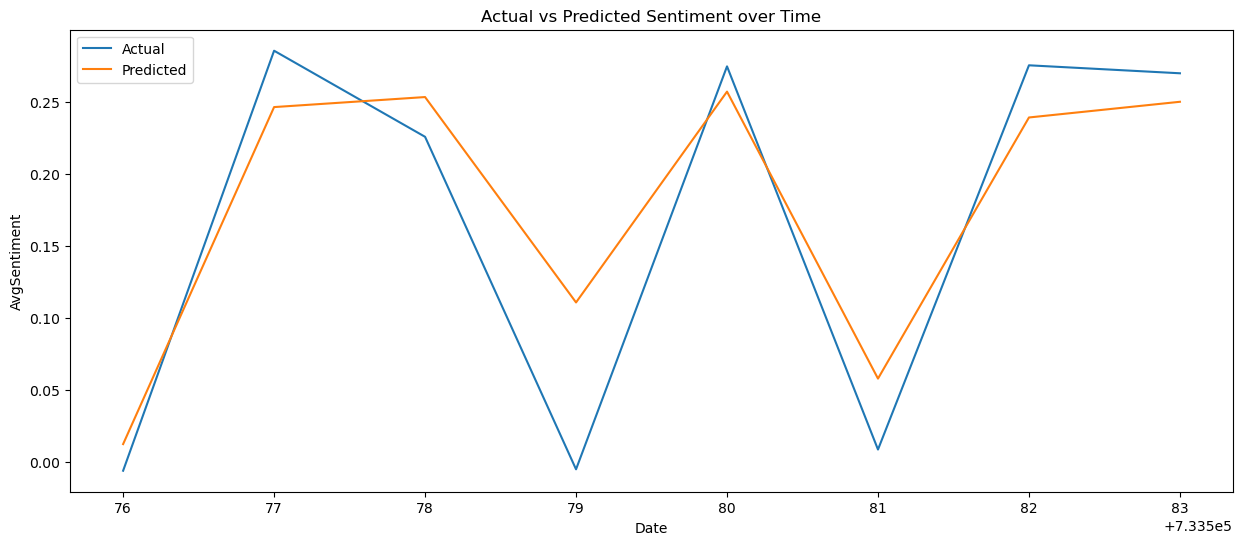

In [17]:
# Extract the last n_steps dates for the test set (since we used them for creating the sequences)
test_dates = dataset['Date'][-len(y_test):]

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test_inverted, label='Actual')
plt.plot(test_dates, y_pred_inverted, label='Predicted')
plt.title('Actual vs Predicted Sentiment over Time')
plt.xlabel('Date')
plt.ylabel('AvgSentiment')
plt.legend()
plt.show()

In [18]:
# Train the model and save the training history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)  # 20% of the data for validation


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.0465

2023-11-07 23:29:56.193798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-07 23:29:56.195784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-07 23:29:56.197187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 984ms/step - loss: 0.0465 - val_loss: 0.0733
Epoch 2/100
1/1 [==============================] - 0s 94ms/step - loss: 0.0464 - val_loss: 0.0733
Epoch 3/100
1/1 [==============================] - 0s 170ms/step - loss: 0.0463 - val_loss: 0.0734
Epoch 4/100
1/1 [==============================] - 0s 133ms/step - loss: 0.0462 - val_loss: 0.0736
Epoch 5/100
1/1 [==============================] - 0s 113ms/step - loss: 0.0461 - val_loss: 0.0738
Epoch 6/100
1/1 [==============================] - 0s 150ms/step - loss: 0.0460 - val_loss: 0.0740
Epoch 7/100
1/1 [==============================] - 0s 94ms/step - loss: 0.0459 - val_loss: 0.0743
Epoch 8/100
1/1 [==============================] - 0s 74ms/step - loss: 0.0458 - val_loss: 0.0744
Epoch 9/100
1/1 [==============================] - 0s 89ms/step - loss: 0.0458 - val_loss: 0.0745
Epoch 10/100
1/1 [==============================] - 0s 138ms/step - loss: 0.0457 - val_loss: 0.0745
Epoch 11/100
1/1 [=======

1/1 [==============================] - 0s 111ms/step - loss: 0.0416 - val_loss: 0.0661
Epoch 84/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0415 - val_loss: 0.0660
Epoch 85/100
1/1 [==============================] - 0s 100ms/step - loss: 0.0415 - val_loss: 0.0658
Epoch 86/100
1/1 [==============================] - 0s 93ms/step - loss: 0.0414 - val_loss: 0.0657
Epoch 87/100
1/1 [==============================] - 0s 105ms/step - loss: 0.0414 - val_loss: 0.0656
Epoch 88/100
1/1 [==============================] - 0s 80ms/step - loss: 0.0413 - val_loss: 0.0654
Epoch 89/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0413 - val_loss: 0.0653
Epoch 90/100
1/1 [==============================] - 0s 93ms/step - loss: 0.0412 - val_loss: 0.0651
Epoch 91/100
1/1 [==============================] - 0s 110ms/step - loss: 0.0412 - val_loss: 0.0650
Epoch 92/100
1/1 [==============================] - 0s 74ms/step - loss: 0.0411 - val_loss: 0.0648
Epoch 93/100
1/1 [=

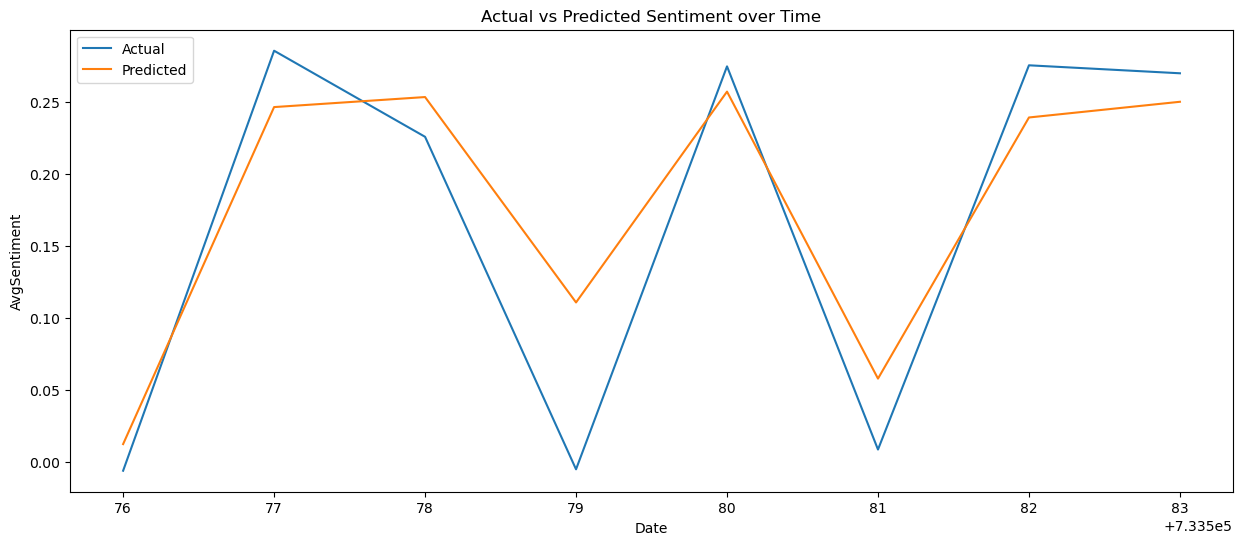

In [19]:
# Extract the last n_steps dates for the test set (since we used them for creating the sequences)
test_dates = dataset['Date'][-len(y_test):]

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test_inverted, label='Actual')
plt.plot(test_dates, y_pred_inverted, label='Predicted')
plt.title('Actual vs Predicted Sentiment over Time')
plt.xlabel('Date')
plt.ylabel('AvgSentiment')
plt.legend()
plt.show()

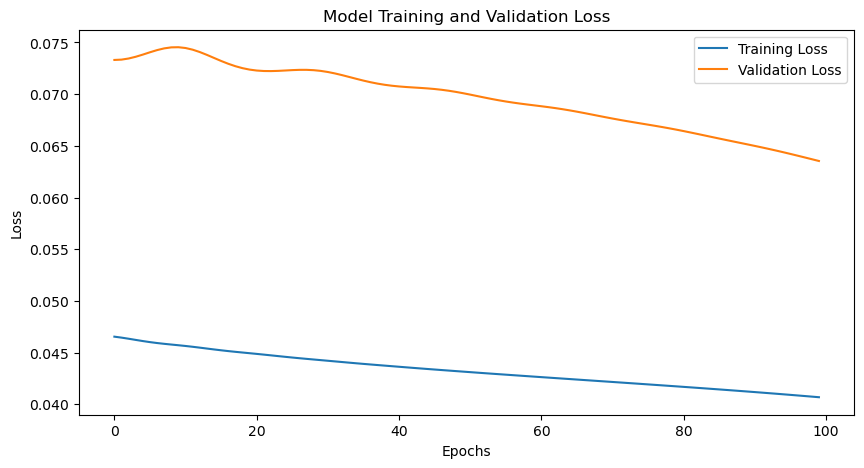

In [20]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error on Test Data: {mse}")
print(f"R-squared on Test Data: {r2}")

1/1 [==============================] - 0s 29ms/step
Mean Squared Error on Test Data: 0.009195418994353992
R-squared on Test Data: 0.9283584510967419


In [22]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

warnings.filterwarnings('ignore')  # Suppress warnings

Epoch 1/100
1/1 [==============================] - 0s 65ms/step - loss: 0.0455
Epoch 2/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0454
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0452
Epoch 4/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0451
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0450
Epoch 6/100
1/1 [==============================] - 0s 69ms/step - loss: 0.0450
Epoch 7/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0449
Epoch 8/100
1/1 [==============================] - 0s 78ms/step - loss: 0.0448
Epoch 9/100
1/1 [==============================] - 0s 52ms/step - loss: 0.0446
Epoch 10/100
1/1 [==============================] - 0s 62ms/step - loss: 0.0445
Epoch 11/100
1/1 [==============================] - 0s 80ms/step - loss: 0.0444
Epoch 12/100
1/1 [==============================] - 0s 51ms/step - loss: 0.0443
Epoch 13/100
1/1 [==============================]

In [23]:
# Forecast future steps, one day at a time
def forecast(model, initial_sequence, n_forecast, n_features):
    forecast_results = []
    current_sequence = initial_sequence.reshape(-1, n_features)
    for _ in range(n_forecast):
        # Predict the next step and retrieve the numerical value
        next_step = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
        # Append the prediction to the results
        forecast_results.append(next_step)
        # Add the prediction to the input sequence for the next forecast
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_step
    return np.array(forecast_results)

# Single feature per step
n_features = 1

# Perform the forecasts
forecast_7_days = forecast(model, X_test[-1], 7, n_features)
forecast_1_month = forecast(model, X_test[-1], 30, n_features)
forecast_3_months = forecast(model, X_test[-1], 90, n_features)

# Inverse transform forecasts to original scale
forecast_7_days_inverted = scaler.inverse_transform(forecast_7_days.reshape(-1, 1))
forecast_1_month_inverted = scaler.inverse_transform(forecast_1_month.reshape(-1, 1))
forecast_3_months_inverted = scaler.inverse_transform(forecast_3_months.reshape(-1, 1))

1/1 [==============================] - 0s 17ms/step


In [24]:
def plot_forecast(train_data, test_data, forecast_data, title):
    plt.figure(figsize=(14, 7))
    
    # Plot train data
    train_len = len(train_data)
    plt.plot(range(train_len), train_data, color='blue', label='Train data')
    
    # Plot test data
    test_len = len(test_data)
    plt.plot(range(train_len, train_len + test_len), test_data, color='orange', label='Test data')
    
    # Plot forecast data
    forecast_len = len(forecast_data)
    plt.plot(range(train_len + test_len, train_len + test_len + forecast_len), forecast_data, color='green', label='Forecast')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

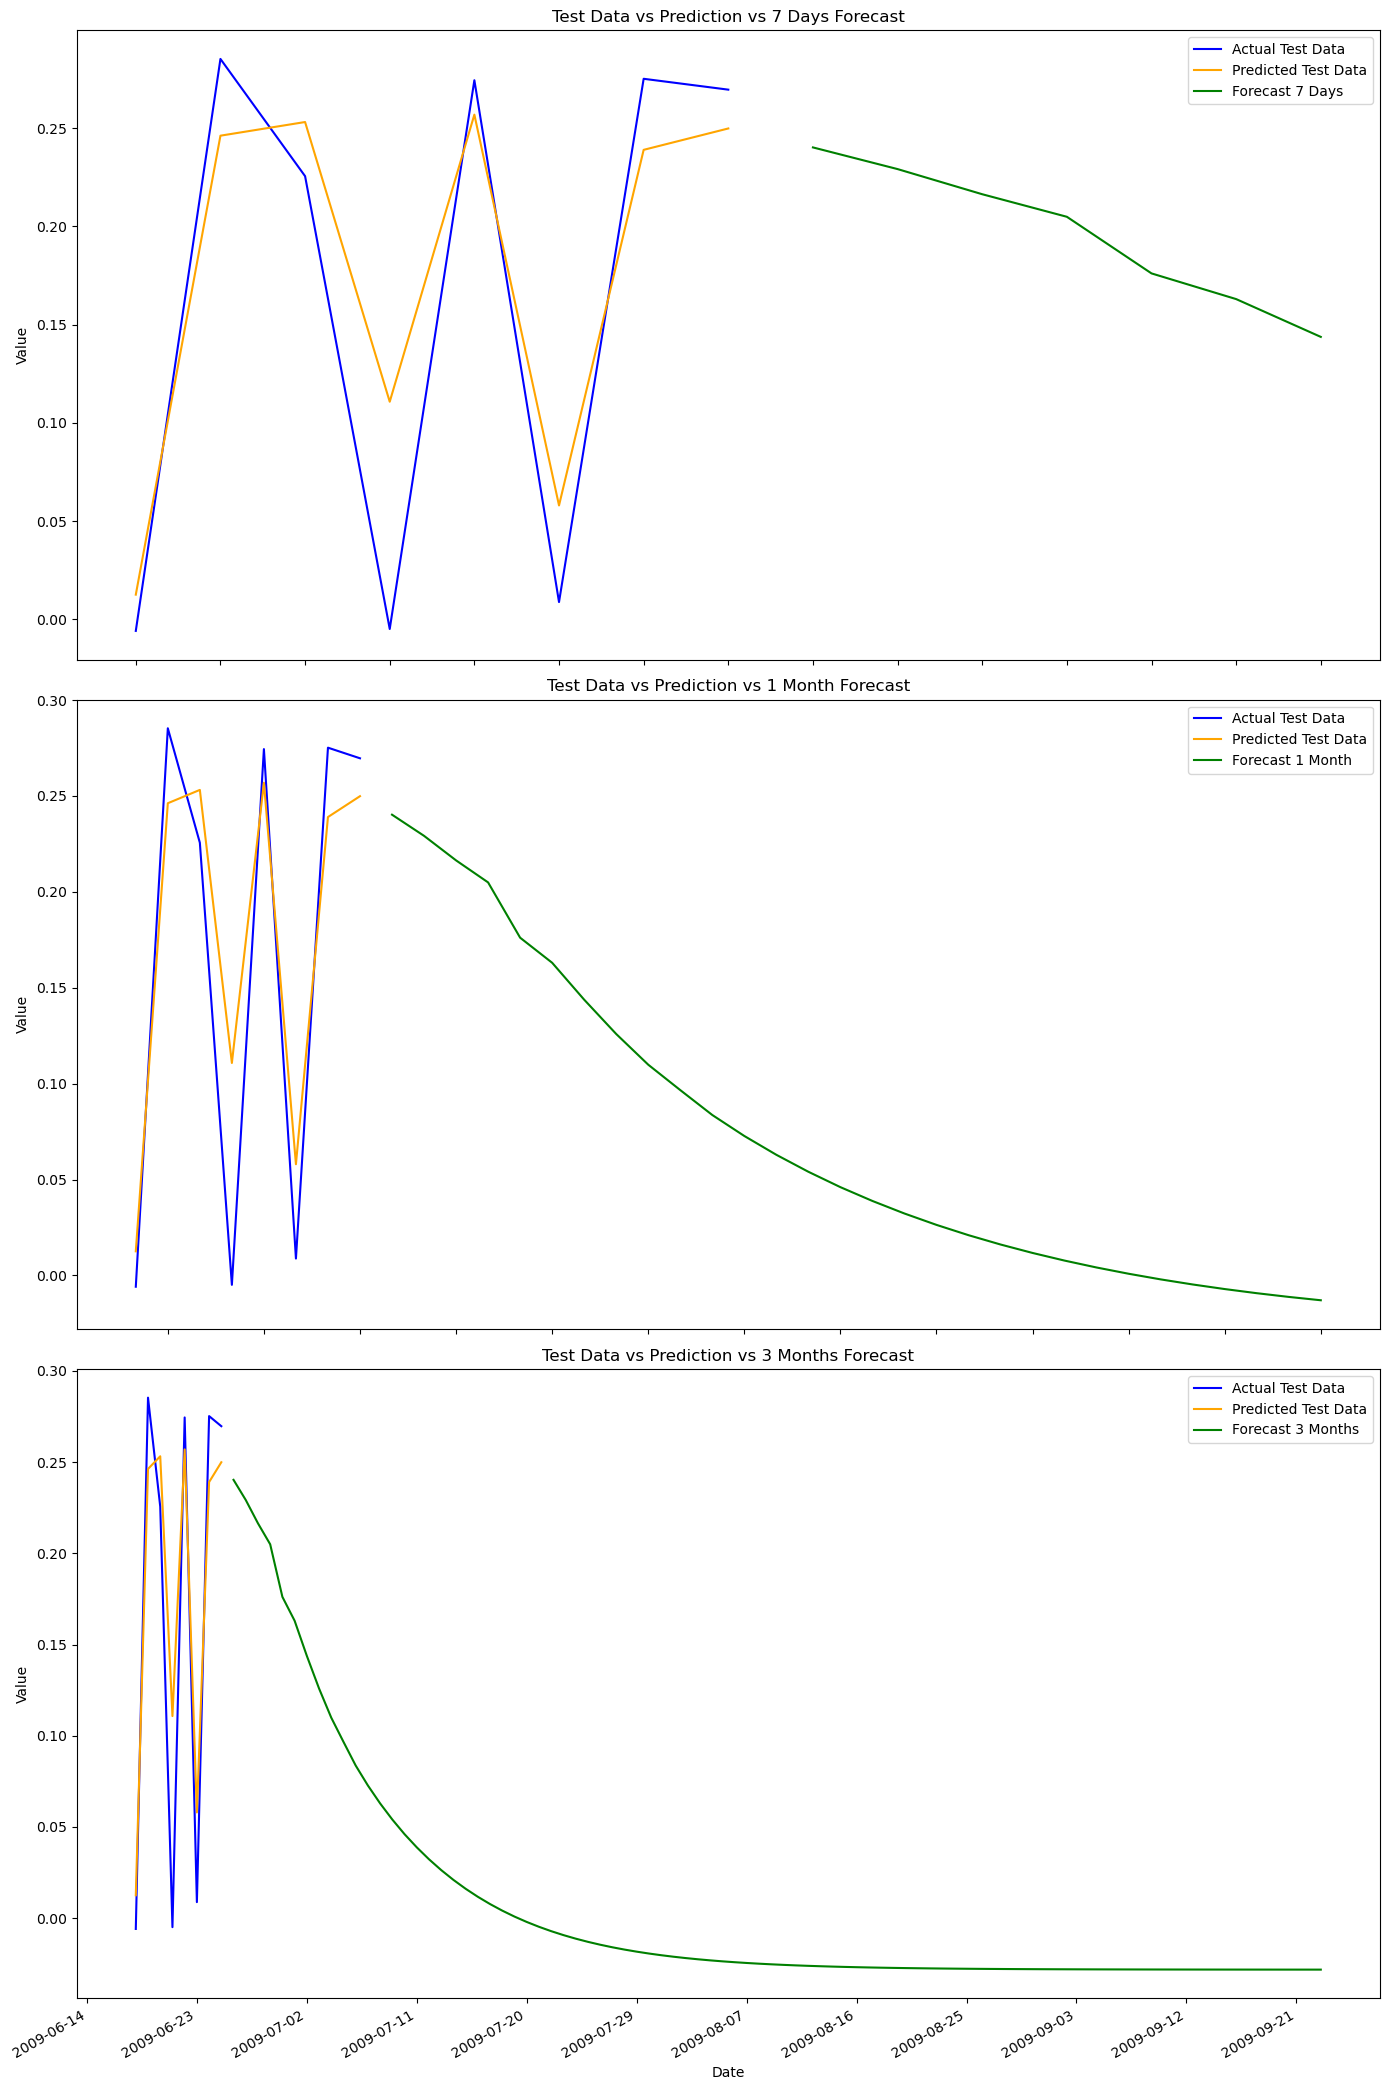

In [25]:
# Extract the last n_steps dates for the test set (as ordinal dates)
test_dates_ord = dataset['Date'][-len(y_test_inverted):].values

def plot_forecasts(test_dates_ord, test_actual, test_predicted, forecasts, titles):
    plt.figure(figsize=(14, 7 * len(forecasts)))  # The size based on the number of plots
    
    for i, (forecast, title) in enumerate(zip(forecasts, titles), 1):
        forecast_dates = [pd.Timestamp.fromordinal(int(test_dates_ord[-1])) + pd.Timedelta(days=d) for d in range(1, len(forecast) + 1)]
        test_dates = [pd.Timestamp.fromordinal(int(date)) for date in test_dates_ord]
        
        plt.subplot(len(forecasts), 1, i)
        
        # Plot actual test data
        plt.plot(test_dates, test_actual, color='blue', label='Actual Test Data')
        
        # Plot predicted test data
        plt.plot(test_dates, test_predicted, color='orange', label='Predicted Test Data')
        
        # Plot forecast data
        plt.plot(forecast_dates, forecast, color='green', label=f'Forecast {title}')
        
        # Formatting plot
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=max(len(forecast) // 10, 1)))
        plt.gcf().autofmt_xdate()  # Rotation
        
        plt.title(f'Test Data vs Prediction vs {title} Forecast')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.tight_layout()

    plt.show()

# Plot for 1 week, 1 month, and 3 months
plot_forecasts(
    test_dates_ord, 
    y_test_inverted, 
    y_pred_inverted, 
    [forecast_7_days_inverted, forecast_1_month_inverted, forecast_3_months_inverted], 
    ['7 Days', '1 Month', '3 Months']
)


# Dashboard Dash.

In [26]:
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objs as go
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib

# Function to create sequences required by the LSTM model
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Function to perform forecasting
def forecast(model, initial_sequence, n_forecast):
    forecast_results = []
    current_sequence = initial_sequence
    for _ in range(n_forecast):
        next_step = model.predict(current_sequence, verbose=0)[0]
        forecast_results.append(next_step)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_step
    return np.array(forecast_results)

# Load the scaler and the model
scaler = joblib.load('/home/hduser/Desktop/scaler.pkl')  
model = load_model('/home/hduser/Desktop/model.h5')  

# Load data
dataset = pd.read_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Preprocess the data
dataset_scaled = scaler.transform(dataset[['AvgSentiment']])

# Create sequences for LSTM
n_steps = 5  # the same number of steps as used during model training
X, y = create_sequences(dataset_scaled, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshaping for LSTM

# Initialize the Dash app
app = Dash(__name__)
app.config.suppress_callback_exceptions = True

# Layout
app.layout = html.Div([
    dcc.Dropdown(
        id='forecast-range-dropdown',
        options=[
            {'label': '1 Week', 'value': 7},
            {'label': '1 Month', 'value': 30},
            {'label': '3 Months', 'value': 90},
        ],
        value=7  # Default value is 1 week
    ),
    dcc.Graph(id='time-series-chart')
])

# Callback for updating the chart
@app.callback(
    Output('time-series-chart', 'figure'),
    [Input('forecast-range-dropdown', 'value')]
)
def update_chart(forecast_range):
    # Prepare the last sequence from the data
    last_sequence = X[-1].reshape((1, n_steps, 1)) 

    # Perform the forecast
    forecast_results = forecast(model, last_sequence, forecast_range)
    forecast_results_inverted = scaler.inverse_transform(forecast_results.reshape(-1, 1))

    # Prepare data for plotting
    last_date = dataset['Date'].iloc[-1]
    forecast_dates = [last_date + pd.Timedelta(days=d) for d in range(1, forecast_range + 1)]

    # Concatenate the last historical date with the forecast dates
    plot_dates = [last_date] + forecast_dates
    # Concatenate the last historical sentiment value with the forecasted sentiments
    last_sentiment_value = [dataset['AvgSentiment'].iloc[-1]]
    plot_sentiments = np.concatenate((last_sentiment_value, forecast_results_inverted.flatten()))

    # Create the figure
    figure = go.Figure()

    # Plot the historical data
    figure.add_trace(go.Scatter(
        x=dataset['Date'],
        y=dataset['AvgSentiment'],
        mode='lines',
        name='Historical'
    ))

    # Plot the forecast data with continuity
    figure.add_trace(go.Scatter(
        x=plot_dates,
        y=plot_sentiments,
        mode='lines+markers',
        name='Forecast'
    ))

    # Update layout
    figure.update_layout(
        title='Sentiment Forecast',
        xaxis_title='Date',
        yaxis_title='Sentiment',
        legend_title='Legend',
        xaxis=dict(
            tickmode='auto',
            nticks=20,
            tickformat='%d %B (%a)<br>%Y'
        )
    )

    return figure

In [27]:
# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True)

# ARIMA

In [28]:
# Load the dataset from CSV file or other source where 'Date' is present
dataset = pd.read_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv')

In [29]:
# Print the column names of the dataset to verify that 'Date' exists
print(dataset.columns)

Index(['Date', 'AvgSentiment'], dtype='object')


In [30]:
from scipy.special import inv_boxcox

Series is not stationary. Differencing will be applied.
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-48.728, Time=1.29 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-48.048, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-52.049, Time=1.03 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-52.722, Time=1.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-49.755, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-53.621, Time=0.33 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-52.744, Time=0.62 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-50.698, Time=0.82 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-51.692, Time=0.25 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=-51.548, Time=0.25 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-53.390, Time=0.14 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-50.888, Time=0.27 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=-54.827, Time=0.07 sec
 ARIMA(0,0,1)(1,1,0)[12]             : AIC=

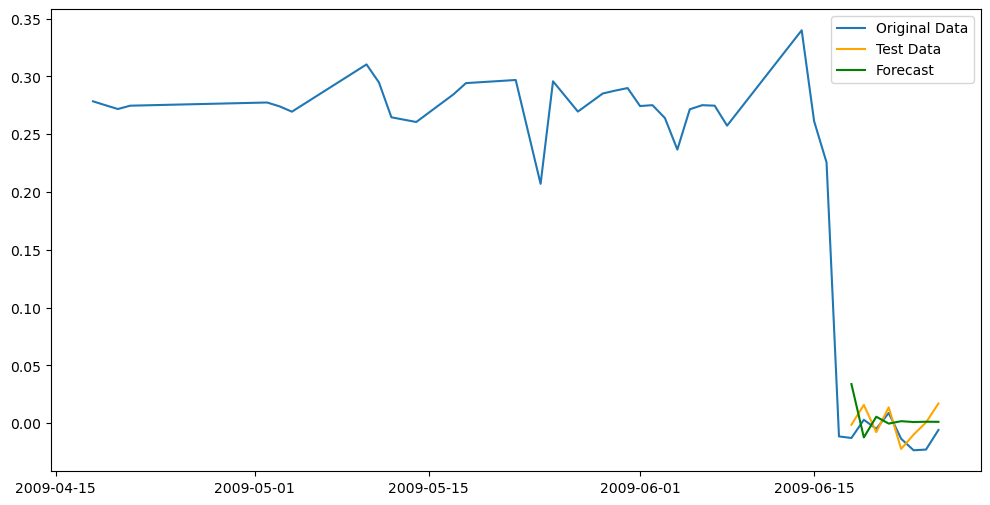

In [31]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt

# Load the dataset
dataset = pd.read_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)

# Function to check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    if result[1] <= 0.05:
        print("Series is stationary.")
        return timeseries
    else:
        print("Series is not stationary. Differencing will be applied.")
        return timeseries.diff().dropna()

# Apply check_stationarity function
dataset['AvgSentiment_Stationary'] = check_stationarity(dataset['AvgSentiment'])

# Apply Box-Cox transformation to the stationary data and drop any resulting NaNs
dataset['AvgSentiment_Stationary'] += 1  # Shift series to ensure positivity
dataset['Transformed'], lambda_ = boxcox(dataset['AvgSentiment_Stationary'])
dataset.dropna(subset=['Transformed'], inplace=True)

# Define train size and split the data into train and test
train_size = int(len(dataset) * 0.8)
train, test = dataset.iloc[:train_size], dataset.iloc[train_size:]

# Fit ARIMA model using auto_arima to find optimal parameters
stepwise_fit = auto_arima(train['Transformed'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

print(stepwise_fit.summary())

# Fit the ARIMA model using the best parameters found by auto_arima
model = ARIMA(train['Transformed'], order=stepwise_fit.order)
results = model.fit()

# Forecast the future values
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

# Inverse the transformations to get the forecast to the original scale
forecast_mean_original_scale = inv_boxcox(forecast_mean, lambda_) - 1

# Plotting the original data, test data, and the forecast
plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['AvgSentiment'], label='Original Data')
plt.plot(test.index, inv_boxcox(test['Transformed'], lambda_) - 1, label='Test Data', color='orange')
plt.plot(test.index, forecast_mean_original_scale, label='Forecast', color='green')
plt.legend()
plt.show()


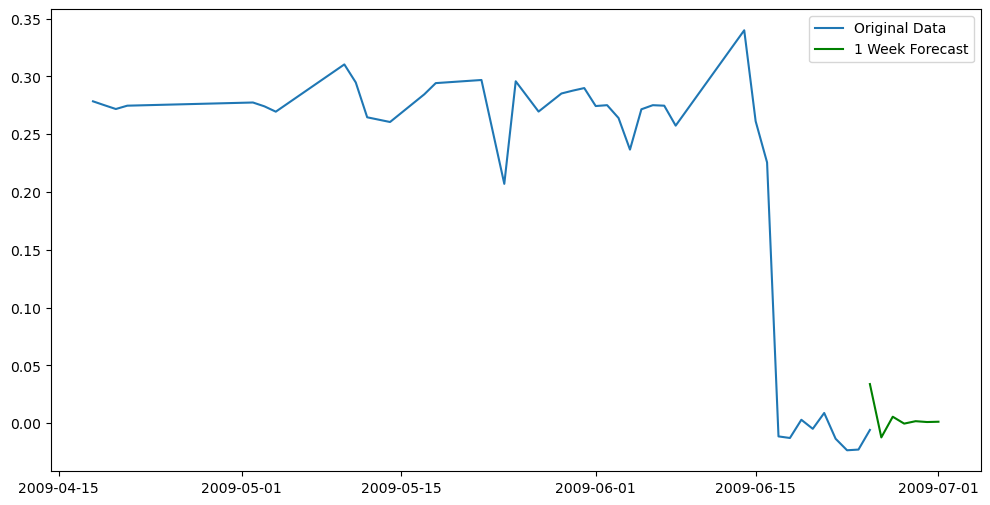

In [32]:
forecast_1week = results.get_forecast(steps=7)
forecast_1week_mean = forecast_1week.predicted_mean
forecast_1week_mean_original_scale = inv_boxcox(forecast_1week_mean, lambda_) - 1

plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['AvgSentiment'], label='Original Data')
plt.plot(pd.date_range(start=dataset.index[-1], periods=7, freq='D'), forecast_1week_mean_original_scale, label='1 Week Forecast', color='green')
plt.legend()
plt.show()


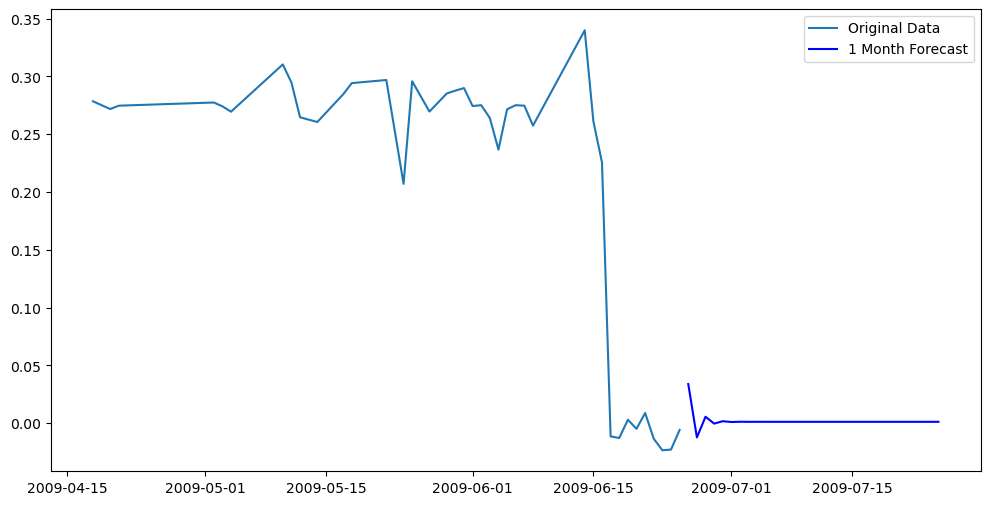

In [33]:
forecast_1month = results.get_forecast(steps=30)
forecast_1month_mean = forecast_1month.predicted_mean
forecast_1month_mean_original_scale = inv_boxcox(forecast_1month_mean, lambda_) - 1

plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['AvgSentiment'], label='Original Data')
plt.plot(pd.date_range(start=dataset.index[-1] + pd.Timedelta(days=1), periods=30, freq='D'), forecast_1month_mean_original_scale, label='1 Month Forecast', color='blue')
plt.legend()
plt.show()

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File ~/miniconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexes/base.py:3653, in Index.get_loc(
    self=Index(['AvgSentiment', 'AvgSentiment_Stationary', 'Transformed'], dtype='object'),
    key='Date'
)
   3652 try:
-> 3653     return self._engine.get_loc(casted_key)
        casted_key = 'Date'
        self = Index(['AvgSentiment', 'AvgSentiment_Stationary', 'Transformed'], dtype='object')
   3654 except KeyError as err:

File ~/miniconda3/envs/myenv/lib/python3.8/site-packages/pandas/_libs/index.pyx:147, in pandas._libs.index.IndexEngine.get_loc()

File ~/miniconda3/envs/myenv/lib/python3.8/site-packages/pandas/_libs/index.pyx:176, in pandas._libs.index.IndexEngine.get_loc()

File pandas/_libs/hashtable_class_helper.pxi:7080, in pandas._libs.hashtable.PyObjectHashTable.get_item()

File pandas/_libs/hashtable_class_helper

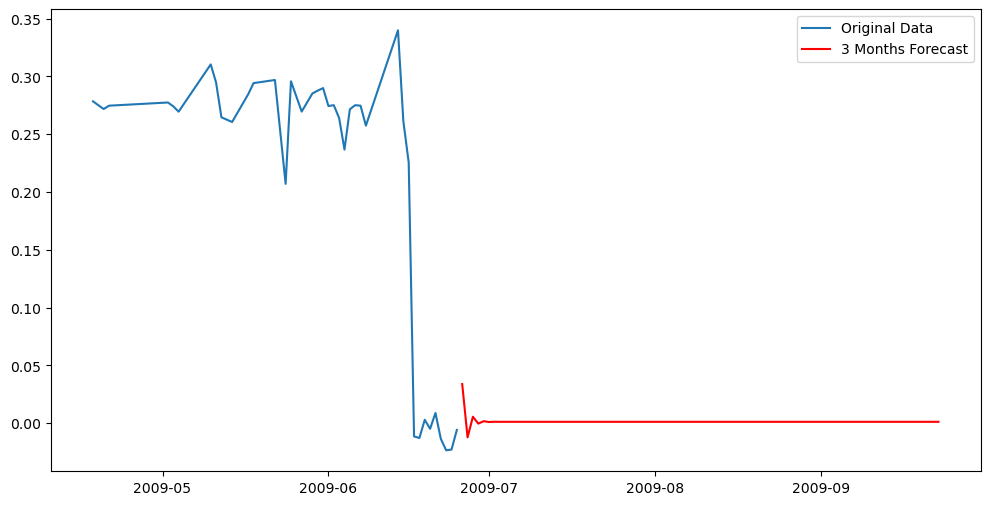

In [34]:
forecast_3months = results.get_forecast(steps=90)
forecast_3months_mean = forecast_3months.predicted_mean
forecast_3months_mean_original_scale = inv_boxcox(forecast_3months_mean, lambda_) - 1

plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['AvgSentiment'], label='Original Data')
plt.plot(pd.date_range(start=dataset.index[-1] + pd.Timedelta(days=1), periods=90, freq='D'), forecast_3months_mean_original_scale, label='3 Months Forecast', color='red')
plt.legend()
plt.show()


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ATest data and 'forecast_mean_original_scale' is the forecasted data
actual = test['AvgSentiment']
predicted = forecast_mean_original_scale

# Calculate MAE
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Square Error (RMSE): {rmse}")



Mean Absolute Error (MAE): 0.019045060230653846
Root Mean Square Error (RMSE): 0.022539928569366444


In [36]:
# After differencing and Box-Cox transformation, check for NaNs
print("NaNs in 'Transformed' series:", dataset['Transformed'].isnull().sum())

# Drop them / fill them
dataset['Transformed'].fillna(method='ffill', inplace=True)

# Drop NaNs:
dataset.dropna(subset=['Transformed'], inplace=True)

# Now, re-split the data into train and test
train, test = dataset['Transformed'][:train_size], dataset['Transformed'][train_size:]

NaNs in 'Transformed' series: 0


# Dashboard Dash. (LSTM & ARIMA)

In [37]:
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objs as go
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib
from statsmodels.tsa.arima.model import ARIMA
import pickle

# Load the scaler and the LSTM model
scaler = joblib.load('/home/hduser/Desktop/scaler.pkl')  
lstm_model = load_model('/home/hduser/Desktop/model.h5')

# Load ARIMA model
with open('/home/hduser/Desktop/arima_model.pkl', 'rb') as pkl:
    arima_model = pickle.load(pkl)

# Load data
dataset = pd.read_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Preprocess the data for LSTM
dataset_scaled = scaler.transform(dataset[['AvgSentiment']])
n_steps = 5  # the same number of steps as used during model training
X, y = create_sequences(dataset_scaled, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshaping for LSTM

# Initialize the Dash app
app = Dash(__name__)

# Layout
app.layout = html.Div([
    dcc.Dropdown(
        id='model-selection-dropdown',
        options=[
            {'label': 'LSTM', 'value': 'LSTM'},
            {'label': 'ARIMA', 'value': 'ARIMA'}
        ],
        value='LSTM'  # Default value is LSTM
    ),
    dcc.Dropdown(
        id='forecast-range-dropdown',
        options=[
            {'label': '1 Week', 'value': 7},
            {'label': '1 Month', 'value': 30},
            {'label': '3 Months', 'value': 90},
        ],
        value=7  # Default value is 1 week
    ),
    dcc.Graph(id='time-series-chart')
])

# Callback for updating the chart
@app.callback(
    Output('time-series-chart', 'figure'),
    [Input('forecast-range-dropdown', 'value'),
     Input('model-selection-dropdown', 'value')]
)
def update_chart(forecast_range, selected_model):
    last_date = dataset['Date'].iloc[-1]
    forecast_results_inverted = None

    if selected_model == 'LSTM':
        last_sequence = X[-1].reshape((1, n_steps, 1)) 
        forecast_results = lstm_forecast(lstm_model, last_sequence, forecast_range)
        forecast_results_inverted = scaler.inverse_transform(forecast_results.reshape(-1, 1)).flatten()
    elif selected_model == 'ARIMA':
        forecast_results = arima_forecast(arima_model, forecast_range)
        forecast_results_inverted = forecast_results.to_numpy().flatten() # Convert to NumPy array and flatten

    forecast_dates = [last_date + pd.Timedelta(days=d) for d in range(1, forecast_range + 1)]
    plot_dates = [last_date] + forecast_dates
    last_sentiment_value = [dataset['AvgSentiment'].iloc[-1]]
    plot_sentiments = np.concatenate((last_sentiment_value, forecast_results_inverted))

    figure = go.Figure()
    figure.add_trace(go.Scatter(
        x=dataset['Date'],
        y=dataset['AvgSentiment'],
        mode='lines',
        name='Historical'
    ))
    figure.add_trace(go.Scatter(
        x=plot_dates,
        y=plot_sentiments,
        mode='lines+markers',
        name='Forecast'
    ))
    figure.update_layout(
        title='Sentiment Forecast',
        xaxis_title='Date',
        yaxis_title='Sentiment',
        legend_title='Legend',
        xaxis=dict(
            tickmode='auto',
            nticks=20,
            tickformat='%d %B (%a)<br>%Y'
        )
    )

    return figure

if __name__ == '__main__':
    app.run_server(debug=True)


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
NameError: name 'lstm_forecast' is not defined

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
NameError: name 'lstm_forecast' is not defined

